# Predicting Subscription Churn for a Telecoms Company

<ol>
        <li><a href="#understanding-the-data">Understanding the Data</a></li>
        <li><a href="#reading-the-data">Reading the Data</a></li>
        <li><a href="#adding-columns">Adding Columns</a></li>
        <li><a href="#general-analysis">General Analysis</a></li>
    </ol>

<h2>Understanding the Data</h2>

The telecom operator Interconnect wanted to be able to forecast client churn. If it was discovered that a user was planning to leave, they would be offered promotional codes and special plan options.

Interconnect provided two types of services:
1. Landline Communications, where phones can be connected to several lines simultaneously.
2. Internet Connectivity. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.

Other services the company provided included:
- Internet Security: Antivirus software and a malicious website blocker
- A dedicated technical support line
- Cloud file storage and data backup
- TV and movie streaming.

Clients had 3 payment options: 'Pay Monthly' or to take out a 1- or 2-year contract. They could use various payment methods and receive an electronic invoice after a transaction.

### Objectives

The objective of this project was to use the company's data to train and compare models to forecast whether users were likely to churn or not. Interconnect's marketing team had collected customer data including personal information and information about their plans and contracts. Models were to be rated and compared according to their Accuracy and their AUC-ROC Scores.

In [88]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cb
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

<h2>Reading the Data</h2>

We first read in the 4 datasets and then investigate them in turn:

In [2]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')  
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    contract = pd.read_csv('/Users/Steve Lewis/practicum_datasets/final_provider/contract.csv')
    internet = pd.read_csv('/Users/Steve Lewis/practicum_datasets/final_provider/internet.csv')
    personal = pd.read_csv('/Users/Steve Lewis/practicum_datasets/final_provider/personal.csv')
    phone = pd.read_csv('/Users/Steve Lewis/practicum_datasets/final_provider/phone.csv')

### The 'Contract' Dataset

In [3]:
display(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


There are 7043 rows and 8 columns in this dataset. We will re-style the column headings to avoid making errors later:

In [4]:
contract.columns = ['customer_id','begin_date', 'end_date', 'type','paperless_billing','payment_method','monthly_charges','total_charges']
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


No null values.  We move on to inspect the 'Internet' dataset.

### The 'Internet' Dataset

In [6]:
display(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [7]:
internet.columns = ['customer_id','internet_service', 'online_security', 'online_backup','device_protection','tech_support','streaming_tv','streaming_movies']
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


### The 'Personal' Dataset

In [9]:
display(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [10]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### The 'Phone' Dataset

In [12]:
display(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [13]:
phone.columns = ['customer_id', 'multiple_lines']
phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [14]:
len(phone['customer_id'].unique())

6361

In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


There are no null values in each of these 4 datasets and all seems to be in order. We move to the next stage of pre-processing the data and readying it for model training.

## Pre-processing the Data

### The Contract Dataset

In this dataset, we first need to change both date columns (`begin_date` and `end_date`) and to the 'datetime' data type and then we will be able to calculate the length of each contract in months. 

However, as we will also want to create the 'target' column (to be called `churned`) for model training from the `end_date` column, we will create a duplicate copy of the `end_date` column for us to perform calculations on. 

In [16]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format ='%Y-%m-%d')
contract['begin_date'].head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: begin_date, dtype: datetime64[ns]

We now create the new column called `end_date_copy`. The contract information is valid as of February 1, 2020, so we will make this the `end_date` for contracts that are ongoing (ie where `end_date` = No).

In [17]:
contract['end_date_copy'] = contract['end_date'].replace('No', '2020-02-01')
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_copy
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020-02-01
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2020-02-01
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01 00:00:00
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2020-02-01
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01 00:00:00


In [18]:
contract['end_date_copy'] = pd.to_datetime(contract['end_date_copy'], format ='%Y-%m-%d')
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_copy
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020-02-01
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2020-02-01
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2020-02-01
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01


In [19]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   end_date_copy      7043 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 495.3+ KB


`begin_date` and `end_date_copy` are now of the datetime type. 

### Calculating Contract Length

We now extract the year and month information from the `begin_date` and `end_date_copy` columns:

In [20]:
contract['begin_year'] = pd.DatetimeIndex(contract['begin_date']).year
contract['begin_month'] = pd.DatetimeIndex(contract['begin_date']).month
contract['end_year'] = pd.DatetimeIndex(contract['end_date_copy']).year
contract['end_month'] = pd.DatetimeIndex(contract['end_date_copy']).month
contract.tail()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_copy,begin_year,begin_month,end_year,end_month
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,2020-02-01,2018,2,2020,2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,2020-02-01,2014,2,2020,2
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,2020-02-01,2019,3,2020,2
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,2019-11-01,2019,7,2019,11
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,6844.5,2020-02-01,2014,8,2020,2


We apply a formula to calculate the length of each contract in months:

In [21]:
contract['contract_length'] = ((contract['end_year'] - contract['begin_year']) * 12) + (contract['end_month'] - contract['begin_month'])
contract.tail()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_copy,begin_year,begin_month,end_year,end_month,contract_length
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,2020-02-01,2018,2,2020,2,24
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,2020-02-01,2014,2,2020,2,72
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,2020-02-01,2019,3,2020,2,11
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,2019-11-01,2019,7,2019,11,4
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,6844.5,2020-02-01,2014,8,2020,2,66


We have successfully calculated the length of each contract in months.

### Creating the Target feature

Next we create a new column (`churned`) from `end_date` which will become the target feature in our model training.

In [22]:
def churn_category(end_date):
    if end_date == 'No':
        churn = 0
    else:
        churn = 1
    return churn

In [23]:
contract['churned'] = contract['end_date'].apply(churn_category)
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_copy,begin_year,begin_month,end_year,end_month,contract_length,churned
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020-02-01,2020,1,2020,2,1,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2020-02-01,2017,4,2020,2,34,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01,2019,10,2019,12,2,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2020-02-01,2016,5,2020,2,45,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01,2019,9,2019,11,2,1


The target feature (`churned`) has been successfully created. 

We will now drop the 'datetime' date columns that we no longer need otherwise they will cause problems when training the models. 

**To avoid data leakage, we delete all the date information except 'begin_month'**:

In [24]:
contract = contract.drop(columns = ['begin_date', 'end_date', 'end_date_copy', 'end_month', 'end_year', 'begin_year'])
contract.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,begin_month,contract_length,churned
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,1,1,0
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.5,4,34,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,10,2,1
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,5,45,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,9,2,1


In [25]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   object 
 6   begin_month        7043 non-null   int64  
 7   contract_length    7043 non-null   int64  
 8   churned            7043 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 495.3+ KB


We need to change the `total_charges` column to a numeric data type, but when we try to do this, the following error is raised: 

`ValueError: Unable to parse string " " at position 488`. 

So let's check how many rows have the empty string " " in the 'total_charges' column.

In [26]:
len(contract.loc[contract['total_charges'] == " ", 'total_charges'])

11

There are 11.  We need to use the `errors = 'coerce'` argument in `to_numeric()` to handle these:

In [27]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors = 'coerce').astype('float')

In [28]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7032 non-null   float64
 6   begin_month        7043 non-null   int64  
 7   contract_length    7043 non-null   int64  
 8   churned            7043 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 495.3+ KB


These 11 observations are now showing up as null values.  Let's have a closer look at them:

In [29]:
contract.loc[contract['total_charges'].isnull(), 'total_charges']

488    NaN
753    NaN
936    NaN
1082   NaN
1340   NaN
3331   NaN
3826   NaN
4380   NaN
5218   NaN
6670   NaN
6754   NaN
Name: total_charges, dtype: float64

We will examine three of these rows:

In [30]:
contract.loc[488]

customer_id                         4472-LVYGI
type                                  Two year
paperless_billing                          Yes
payment_method       Bank transfer (automatic)
monthly_charges                          52.55
total_charges                              NaN
begin_month                                  2
contract_length                              0
churned                                      0
Name: 488, dtype: object

In [31]:
contract.loc[1082]

customer_id            4367-NUYAO
type                     Two year
paperless_billing              No
payment_method       Mailed check
monthly_charges             25.75
total_charges                 NaN
begin_month                     2
contract_length                 0
churned                         0
Name: 1082, dtype: object

In [32]:
contract.loc[4380]

customer_id            2520-SGTTA
type                     Two year
paperless_billing              No
payment_method       Mailed check
monthly_charges              20.0
total_charges                 NaN
begin_month                     2
contract_length                 0
churned                         0
Name: 4380, dtype: object

It appears that these contracts had only just started on February 1, 2020.  They don't provide useful information for the model, so we will delete them.

In [33]:
feb_20_contracts = contract[contract['total_charges'].isnull()]

In [34]:
contract = contract.drop(feb_20_contracts.index)

In [35]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   type               7032 non-null   object 
 2   paperless_billing  7032 non-null   object 
 3   payment_method     7032 non-null   object 
 4   monthly_charges    7032 non-null   float64
 5   total_charges      7032 non-null   float64
 6   begin_month        7032 non-null   int64  
 7   contract_length    7032 non-null   int64  
 8   churned            7032 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 549.4+ KB


These contracts have now been deleted from the dataset.  

Let's look at the remaining 'object' columns:

In [36]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: type, dtype: int64

In [37]:
contract['paperless_billing'].value_counts()

Yes    4168
No     2864
Name: paperless_billing, dtype: int64

In [38]:
contract['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: payment_method, dtype: int64

These will be encoded with One Hot Encoding when we prepare the data for training.

We will now check for duplicate customer ids:

In [39]:
len(contract['customer_id'].unique())

7032

7032 observations and 7032 unique ids, so no duplicates.

We will now move to the 'Internet' dataset.

### The Internet Dataset

In [40]:
display(internet)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


We check to see if there are duplicate IDs:

In [41]:
len(internet['customer_id'].unique())

5517

There are no duplicate IDs.  We will check how many categories there are in the 'internet_service' column:

In [42]:
internet['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

These will also be encoded later using 'One Hot Encoding'.

### The 'Personal' Dataset

We check that there are no duplicate customer IDs in this dataset:

In [43]:
len(personal['customer_id'].unique())

7043

In [44]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

### The 'Phone' Dataset

Finally, we review the Phone dataset:

In [45]:
phone.shape

(6361, 2)

We perform the same check to make sure there are no duplicate IDs:

In [46]:
len(phone['customer_id'].unique())

6361

There are no duplicate IDs.

In [47]:
phone['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

## Joining the 4 Datasets

We will now combine all 4 datsets. 

We first join the Internet dataset to the Contract dataset. When combining the datasets, some null values will be introduced.  We will set these as 'N/A'.

In [48]:
temp_1 = contract.merge(internet, on='customer_id', how = 'left').fillna('N/A')
temp_1.shape

(7032, 16)

Lets look at a random sample of 5 rows to make sure the join has been completed successfully:

In [49]:
temp_1.sample(5)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,begin_month,contract_length,churned,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
413,5973-EJGDP,Month-to-month,Yes,Electronic check,87.35,4473.00,11,51,0,Fiber optic,No,Yes,Yes,Yes,No,No
2024,6481-OGDOO,One year,Yes,Credit card (automatic),90.60,6056.15,3,67,1,Fiber optic,Yes,Yes,No,No,No,Yes
4364,3372-CDXFJ,One year,No,Bank transfer (automatic),24.50,343.60,1,13,0,N/A,N/A,N/A,N/A,N/A,N/A,N/A
5287,8745-PVESG,One year,Yes,Credit card (automatic),41.10,2258.25,5,57,0,DSL,Yes,No,Yes,Yes,No,No
112,5712-AHQNN,Month-to-month,Yes,Electronic check,91.65,3954.10,7,43,0,Fiber optic,No,Yes,Yes,No,Yes,No


In [50]:
temp_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   type               7032 non-null   object 
 2   paperless_billing  7032 non-null   object 
 3   payment_method     7032 non-null   object 
 4   monthly_charges    7032 non-null   float64
 5   total_charges      7032 non-null   float64
 6   begin_month        7032 non-null   int64  
 7   contract_length    7032 non-null   int64  
 8   churned            7032 non-null   int64  
 9   internet_service   7032 non-null   object 
 10  online_security    7032 non-null   object 
 11  online_backup      7032 non-null   object 
 12  device_protection  7032 non-null   object 
 13  tech_support       7032 non-null   object 
 14  streaming_tv       7032 non-null   object 
 15  streaming_movies   7032 non-null   object 
dtypes: float64(2), int64(3),

We now join the personal dataset to the combined contract/internet dataset:

In [51]:
temp_2 = temp_1.merge(personal, on='customer_id', how = 'left').fillna('N/A')
temp_2.shape

(7032, 20)

Finally, we join the phone dataset to the combind contract/internet/personal dataset:

In [52]:
df = temp_2.merge(phone, on='customer_id', how = 'left').fillna('N/A')
df.shape

(7032, 21)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   type               7032 non-null   object 
 2   paperless_billing  7032 non-null   object 
 3   payment_method     7032 non-null   object 
 4   monthly_charges    7032 non-null   float64
 5   total_charges      7032 non-null   float64
 6   begin_month        7032 non-null   int64  
 7   contract_length    7032 non-null   int64  
 8   churned            7032 non-null   int64  
 9   internet_service   7032 non-null   object 
 10  online_security    7032 non-null   object 
 11  online_backup      7032 non-null   object 
 12  device_protection  7032 non-null   object 
 13  tech_support       7032 non-null   object 
 14  streaming_tv       7032 non-null   object 
 15  streaming_movies   7032 non-null   object 
 16  gender             7032 

The joins have been successfully executed.  The single dataset has 7032 rows and 21 columns.

## Exploratory Data Analysis (EDA)

Let's take a closer look at the numeric features:

In [54]:
df.describe()

,monthly_charges,total_charges,begin_month,contract_length,churned,senior_citizen
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,6.428185,32.421786,0.265785,0.162400
std,30.085974,2266.771362,3.576972,24.545260,0.441782,0.368844
min,18.250000,18.800000,1.000000,1.000000,0.000000,0.000000
25%,35.587500,401.450000,3.000000,9.000000,0.000000,0.000000
50%,70.350000,1397.475000,6.000000,29.000000,0.000000,0.000000
75%,89.862500,3794.737500,10.000000,55.000000,1.000000,0.000000
max,118.750000,8684.800000,12.000000,72.000000,1.000000,1.000000


Monthly charges range from 18.25 to 118.75.  

The maximum contract length is 72 months and there are a small number of heavy users that are skewing the maximum of `total_charges`

We now investigate the distribution of monthly charges and of contract length for each of the 3 contract types:

In [55]:
types = df['type'].value_counts().index
types

Index(['Month-to-month', 'Two year', 'One year'], dtype='object')

<function matplotlib.pyplot.show(close=None, block=None)>

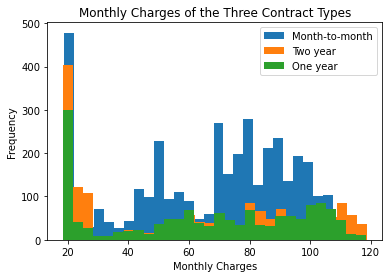

In [89]:
for type in types:
    df[df['type'] == type]['monthly_charges'].plot(kind = 'hist', bins = 30)
    plt.title('Monthly Charges of the Three Contract Types')
plt.legend(types)
plt.xlabel('Monthly Charges')
plt.show

Many contracts are on the lowest monthly charge. At every price range there are more month-to-month contracts than other contracts except at the price range of 22-26 USD and over 110 USD.

<function matplotlib.pyplot.show(close=None, block=None)>

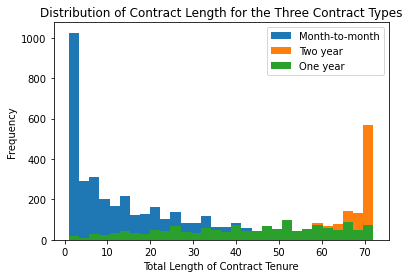

In [92]:
for type in types:
    df[df['type'] == type]['contract_length'].plot(kind = 'hist', bins = 30)
    plt.title('Distribution of Contract Length for the Three Contract Types')
plt.legend(types)
plt.xlabel('Total Length of Contract Tenure')
plt.show

Length of month-to-month contracts tend to be shorter than the other types. However, one year contracts are most popular for total tenures of between 40 and 60 months and Two year contracts are most popular for tenures of 60 months or longer.

## Preparing for Model Training

We will now prepare the data for training the models as follows:
- Delete columns that will not be useful for the model (`customer_id`)
- Encode categorical variables
- Separate the target variable from the features
- Split the data into training (75%) and validation (25%) sets
- Standardise scales
- Examine the balance of the classes and adjust them if necessary.

First deleting the `customer_id` column as it will not be useful for the model:

In [59]:
df = df.drop(columns = ['customer_id'])
df.shape

(7032, 20)

Before we split the data we will encode the categorical variables using One Hot Encoding:

In [60]:
categorical_data = ['type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
'streaming_movies', 'gender', 'partner', 'dependents', 'multiple_lines']

In [61]:
df_OHE = pd.get_dummies(df, columns=categorical_data, drop_first = True)
df_OHE.shape

(7032, 31)

The encoding has been successful and the dataset now has 31 columns (an increase of 11).

We now separate the target variables (y) from the features (X):

In [62]:
X = df_OHE.drop(columns = ['churned'])
X.shape

(7032, 30)

In [63]:
y = df_OHE['churned']
y.shape

(7032,)

Splitting the data into training (75%) and validation (25%) sets:

In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(5274, 30)
(1758, 30)
(5274,)
(1758,)


We will now investigate if the classes are balanced:

In [65]:
def counter(target):
    count_1 = 0
    count_0 = 0
    for i in target:
        if i == 1:
            count_1 += 1
        elif i == 0:
            count_0 += 1
    print ('No of ones =', count_1)
    print ('No of zeros =', count_0)
    print ('Total =', count_1 + count_0)

In [66]:
counter(y_train)

No of ones = 1404
No of zeros = 3870
Total = 5274


We discover that there are almost 3 times as many negative class probabilities, ie zeros (= not churned) as there are positive ones ie ones (= churned).  

We will therefore use the upsampling technique to address this class imbalance. First we create the upsampling function:

In [67]:
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)

    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=12345)

    return X_upsampled, y_upsampled

Now we apply the upsampling function to the trainging set data:

In [68]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 3)

In [69]:
counter(y_upsampled)

No of ones = 4212
No of zeros = 3870
Total = 8082


In [70]:
X_upsampled.shape

(8082, 30)

In [71]:
y_upsampled.shape

(8082,)

The updampling had address the class imbalance.

Lastly, we standardise the scales for all features:

In [72]:
scaler = StandardScaler()
scaler.fit(X_upsampled)
X_upsampled_scaled = scaler.transform(X_upsampled)
X_valid_scaled = scaler.transform(X_valid)

The data is now ready for training.

## Training Models 

We will train the following models and calculate **AUC ROC** and **Accuracy** for each:

- Dummy Classifier that returns the most frequent class label in the y argument passed to fit
- Logistic Regression
- Decision Tree Classifier, tuning the `max_depth` hyperparameter
- Random Forest Classifier, tuning the `n_estimators` hyperparameter
- Random Forest Classifier with Cross Validation
- LGBM Classifier, varying the `num_leaves` and `max_depth` hyperparameters

### Dummy Classifier

This will be our baseline model:

In [73]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_upsampled_scaled, y_upsampled)
valid_predictions = dummy.predict(X_valid_scaled)
valid_probabilities = dummy.predict_proba(X_valid_scaled)
valid_probabilities_one = valid_probabilities[:, 1]

dummy_auc_roc = roc_auc_score(y_valid, valid_probabilities_one)
dummy_accuracy = accuracy_score(y_valid, valid_predictions)

print('AUC ROC =', dummy_auc_roc, '|', 'Accuracy =', dummy_accuracy)

AUC ROC = 0.5 | Accuracy = 0.2645051194539249


### Logistic Regression

In [74]:
lr_model = LogisticRegression(random_state=12345, solver='liblinear')
lr_model.fit(X_upsampled_scaled, y_upsampled)
valid_predictions = lr_model.predict(X_valid_scaled)
valid_probabilities = lr_model.predict_proba(X_valid_scaled)
valid_probabilities_one = valid_probabilities[:, 1] # to access the 2nd column(the positive class probability, ie of 1)

lr_auc_roc = roc_auc_score(y_valid, valid_probabilities_one)
lr_accuracy = accuracy_score(y_valid, valid_predictions)

print('AUC ROC =', lr_auc_roc, '|', 'Accuracy =', lr_accuracy)

AUC ROC = 0.8539796588745021 | Accuracy = 0.7480091012514221


### Decision Tree Classifier

We will optimise the `max_depth` hyperparameter to maximise the AUC ROC:

In [75]:
for depth in range(1,15):

    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(X_upsampled_scaled, y_upsampled)
    valid_predictions = model.predict(X_valid_scaled)
    valid_probabilities = model.predict_proba(X_valid_scaled)
    valid_probabilities_one = valid_probabilities[:, 1]

    auc_roc = roc_auc_score(y_valid, valid_probabilities_one)
    accuracy = accuracy_score(y_valid, valid_predictions)

    print('max_depth =', depth, '|', 'AUC ROC =', auc_roc, '|', 'Accuracy =', accuracy)

max_depth = 1 | AUC ROC = 0.6802409999251553 | Accuracy = 0.6501706484641638
max_depth = 2 | AUC ROC = 0.756192567089955 | Accuracy = 0.6501706484641638
max_depth = 3 | AUC ROC = 0.8026453442440269 | Accuracy = 0.7343572241183163
max_depth = 4 | AUC ROC = 0.8234563281191527 | Accuracy = 0.7042093287827076
max_depth = 5 | AUC ROC = 0.8551780056383005 | Accuracy = 0.7627986348122867
max_depth = 6 | AUC ROC = 0.8710667032574075 | Accuracy = 0.7736063708759955
max_depth = 7 | AUC ROC = 0.8670874601867791 | Accuracy = 0.7747440273037542
max_depth = 8 | AUC ROC = 0.8620171477517484 | Accuracy = 0.7940841865756542
max_depth = 9 | AUC ROC = 0.858889471014312 | Accuracy = 0.7935153583617748
max_depth = 10 | AUC ROC = 0.8518549010802585 | Accuracy = 0.8048919226393629
max_depth = 11 | AUC ROC = 0.8423787308002562 | Accuracy = 0.8111490329920364
max_depth = 12 | AUC ROC = 0.8407645801628287 | Accuracy = 0.8333333333333334
max_depth = 13 | AUC ROC = 0.8238846061089906 | Accuracy = 0.83048919226393

The highest AUC ROC is obtained when max_depth = 6:

In [76]:
dt_model = DecisionTreeClassifier(random_state=12345, max_depth=6)
dt_model.fit(X_upsampled_scaled, y_upsampled)
valid_predictions = dt_model.predict(X_valid_scaled)
valid_probabilities = dt_model.predict_proba(X_valid_scaled)
valid_probabilities_one = valid_probabilities[:, 1]

dt_auc_roc = roc_auc_score(y_valid, valid_probabilities_one)
dt_accuracy = accuracy_score(y_valid, valid_predictions)

print('AUC ROC =', dt_auc_roc, '|', 'Accuracy =', dt_accuracy)

AUC ROC = 0.8710667032574075 | Accuracy = 0.7736063708759955


### Random Forest Classifier

We will optimise the `n_estimators` hyperparameter to maximise the AUC ROC:

In [77]:
for estimator in range(35,65):
    model = RandomForestClassifier(random_state = 12345, n_estimators = estimator)
    model.fit(X_upsampled_scaled, y_upsampled)
    valid_predictions = model.predict(X_valid_scaled)
    valid_probabilities = model.predict_proba(X_valid_scaled)
    valid_probabilities_one = valid_probabilities[:, 1]

    auc_roc = roc_auc_score(y_valid, valid_probabilities_one)
    accuracy = accuracy_score(y_valid, valid_predictions)

    print('n_estimators=', estimator, '|', 'AUC ROC =', auc_roc, '|', 'Accuracy =', accuracy)

n_estimators= 35 | AUC ROC = 0.8695806202130578 | Accuracy = 0.8321956769055745
n_estimators= 36 | AUC ROC = 0.8693718866684963 | Accuracy = 0.8350398179749715
n_estimators= 37 | AUC ROC = 0.8698467346921804 | Accuracy = 0.8310580204778157
n_estimators= 38 | AUC ROC = 0.8707565135676804 | Accuracy = 0.8373151308304891
n_estimators= 39 | AUC ROC = 0.8713278280900465 | Accuracy = 0.8321956769055745
n_estimators= 40 | AUC ROC = 0.8716596395812024 | Accuracy = 0.8361774744027304
n_estimators= 41 | AUC ROC = 0.8714209681577392 | Accuracy = 0.8310580204778157
n_estimators= 42 | AUC ROC = 0.8717785594890602 | Accuracy = 0.8361774744027304
n_estimators= 43 | AUC ROC = 0.8713694084774095 | Accuracy = 0.8304891922639362
n_estimators= 44 | AUC ROC = 0.8714725278380694 | Accuracy = 0.8327645051194539
n_estimators= 45 | AUC ROC = 0.8716288700945538 | Accuracy = 0.8310580204778157
n_estimators= 46 | AUC ROC = 0.8726633901321426 | Accuracy = 0.8350398179749715
n_estimators= 47 | AUC ROC = 0.872971084

The highest AUC ROC is obtained when `n_estimators` = 62:

In [78]:
rf_model = RandomForestClassifier(random_state = 12345, n_estimators = 62)
rf_model.fit(X_upsampled_scaled, y_upsampled)
valid_predictions = rf_model.predict(X_valid_scaled)
valid_probabilities = rf_model.predict_proba(X_valid_scaled)
valid_probabilities_one = valid_probabilities[:, 1]

rf_auc_roc = roc_auc_score(y_valid, valid_probabilities_one)
rf_accuracy = accuracy_score(y_valid, valid_predictions)
print('AUC ROC =', rf_auc_roc, '|', 'Accuracy =', rf_accuracy)

AUC ROC = 0.8767856697352993 | Accuracy = 0.838452787258248


### Random Forest Classifier with Cross Validation 

We will investigate if we can increase the AUC ROC and Accuracy of the Random Forest Classifier by using Cross Validation:

In [79]:
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier(random_state = 12345, n_estimators = 62)

In [80]:
roc_auc_scores = cross_val_score(model, X_upsampled_scaled, y_upsampled, cv=10, scoring = 'roc_auc')
rf_cv_auc_roc = roc_auc_scores.mean()
print(roc_auc_scores)
print('AUC ROC = {:.3f}'.format(rf_cv_auc_roc))

[0.99649142 0.99863453 0.99407096 0.99296924 0.99782418 0.99569746
 0.99383159 0.99630509 0.98997097 0.99573122]
AUC ROC = 0.995


In [81]:
accuracy_scores = cross_val_score(model, X_upsampled_scaled, y_upsampled, cv=10, scoring = 'accuracy')
rf_cv_accuracy = accuracy_scores.mean()
print(accuracy_scores)
print('Accuracy = {:.3f}'.format(rf_cv_accuracy))

[0.95055624 0.9394314  0.94059406 0.93935644 0.95420792 0.93193069
 0.94183168 0.94430693 0.93316832 0.94925743]
Accuracy = 0.942


Yes, Cross Validation has helped to increase both scores.

We nopw turn to Gradient Boosting algorithyms to see if they perform any better:

### LightGBM Classifier

LightGBM (light gradient boosting machine) is a fast and accurate model that uses gradient boosting training. Model complexity is controlled by the num_leaves and the max_depth parameters.

In [82]:
for leaves in range(10, 200, 10):
    model = lgb.LGBMClassifier(num_leaves=leaves, learning_rate=0.1, n_estimators=100, max_depth=12, seed = 12345)
    model.fit(X_upsampled_scaled, y_upsampled)
    valid_predictions = model.predict(X_valid_scaled)
    valid_probabilities = model.predict_proba(X_valid_scaled)
    valid_probabilities_one = valid_probabilities[:, 1]

    auc_roc = roc_auc_score(y_valid, valid_probabilities_one)
    accuracy = accuracy_score(y_valid, valid_predictions)

    print('num_leaves =', leaves, '|', 'AUC ROC =', auc_roc, '|', 'Accuracy =', accuracy)

num_leaves = 10 | AUC ROC = 0.9457409209224192 | Accuracy = 0.8651877133105802
num_leaves = 20 | AUC ROC = 0.9634774509559332 | Accuracy = 0.897042093287827
num_leaves = 30 | AUC ROC = 0.9784547064840456 | Accuracy = 0.9385665529010239
num_leaves = 40 | AUC ROC = 0.9955409192592038 | Accuracy = 0.9806598407281001
num_leaves = 50 | AUC ROC = 0.996525542831957 | Accuracy = 0.9852104664391353
num_leaves = 60 | AUC ROC = 0.9952365508237074 | Accuracy = 0.9795221843003413
num_leaves = 70 | AUC ROC = 0.9951301050320585 | Accuracy = 0.9829351535836177
num_leaves = 80 | AUC ROC = 0.9962045422415154 | Accuracy = 0.9840728100113766
num_leaves = 90 | AUC ROC = 0.9961629618541525 | Accuracy = 0.9823663253697383
num_leaves = 100 | AUC ROC = 0.9954311470365659 | Accuracy = 0.9761092150170648
num_leaves = 110 | AUC ROC = 0.9950037006544752 | Accuracy = 0.9766780432309442
num_leaves = 120 | AUC ROC = 0.9936265582250164 | Accuracy = 0.9715585893060296
num_leaves = 130 | AUC ROC = 0.9942935076383173 | A

The highest AUC ROC is obtained when max_depth=12 and num_leaves = 50:

In [83]:
LGBM_model = lgb.LGBMClassifier(num_leaves=50, learning_rate=0.1, n_estimators=100, max_depth=12, seed = 12345)
LGBM_model.fit(X_upsampled_scaled, y_upsampled)
LGBM_valid_predictions = LGBM_model.predict(X_valid_scaled)
valid_probabilities = LGBM_model.predict_proba(X_valid_scaled)
valid_probabilities_one = valid_probabilities[:, 1]

LGBM_auc_roc = roc_auc_score(y_valid, valid_probabilities_one)
LGBM_accuracy = accuracy_score(y_valid, LGBM_valid_predictions)

print('AUC ROC =', LGBM_auc_roc, '|', 'Accuracy =', LGBM_accuracy)

AUC ROC = 0.996525542831957 | Accuracy = 0.9852104664391353


## Results and Conclusions

In [84]:
columns = ['Model', 'AUC ROC', 'Accuracy']
dummy = ['Dummy Classifier (baseline)', dummy_auc_roc, dummy_accuracy]
lr = ['Logistic Regression', lr_auc_roc, lr_accuracy]
dt = ['Decision Tree Classifier', dt_auc_roc, dt_accuracy]
rf = ['Random Forest Classifier', rf_auc_roc, rf_accuracy]
rf_cv = ['Random Forest Classifier with Cross Validation', rf_cv_auc_roc, rf_cv_accuracy]
lgbm = ['LGBM Classifier', LGBM_auc_roc, LGBM_accuracy]

In [85]:
results = pd.DataFrame([dummy, lr, dt, rf, rf_cv, lgbm], columns=list(columns))
results

,Model,AUC ROC,Accuracy
0,Dummy Classifier (baseline),0.500000,0.264505
1,Logistic Regression,0.853980,0.748009
2,Decision Tree Classifier,0.871067,0.773606
3,Random Forest Classifier,0.876786,0.838453
4,Random Forest Classifier with Cross Validation,0.995153,0.942464
5,LGBM Classifier,0.996526,0.985210


### Conclusions:

The LGBM Classifier performed the best on the data with an AUC ROC of 0.9965 and Accuracy of 0.9852.

Of the models without gradient boosting, the Random Forest Classifier with Cross Validation did almost as well with an AUC ROC of 0.9951 and an Accuracy of 0.9415.

However, both of these results are very good. 

To picture this visually, here is the confusion matrix for the LGBM Classifier:

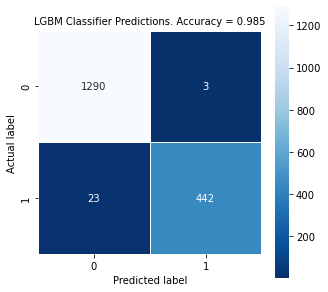

In [86]:
conf_matrix = confusion_matrix(y_valid, LGBM_valid_predictions)

plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('LGBM Classifier Predictions. Accuracy = {:.3f}'.format(LGBM_accuracy), size = 10);

Of the 1758 observations in the validation set, 442 were correctly identified as being labelled `1` and 1290 were correctly identified as being labelled `0`.  Only 26 of the observations were mis-identified: 23 were `1`, but were predicted as `0` and 3 were actually `0` but were predicted to be `1`.